In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist, mnist_transform
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

In [6]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])

train_loader, test_loader = mnist(batch_size=200, valid=0, transform=mnist_transform)

In [7]:
class Encoder(nn.Module):
    def __init__(self, interm_size=32, latent_size=32, act=torch.relu):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, interm_size)
        self.fc2 = nn.Linear(interm_size, latent_size)
        self.act = act
    
    def forward(self, x):
        interm = self.act(self.fc1(x))
        latent = self.act(self.fc2(interm))
        return latent
    
class Decoder(nn.Module):
    def __init__(self, interm_size=32, latent_size=32, act=torch.relu):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, interm_size)
        self.fc2 = nn.Linear(interm_size, 28*28)
        self.act = act
    
    def forward(self, x):
        interm = self.act( self.fc1(x) )
        output = torch.tanh( self.fc2(interm) ) 
        return output

In [8]:
class Net(nn.Module):
    def __init__(self, interm_size=32, latent_size=32, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.E = Encoder(interm_size, latent_size)
        self.D = Decoder(interm_size, latent_size)
        self.loss_fn = loss_fn
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        h = self.E(x)
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

In [9]:
models = {'64-2': Net(64,2), '128-2': Net(128,2), '64-32': Net(64,32), '128-32': Net(128,32)}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [10]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, data)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 150 == 0:
            line = 'Train Epoch: {} [{:05d}/{}] '.format(
                epoch, batch_idx * len(data), train_size)
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{:05d}/{}] '.format(
            epoch, batch_idx * len(data), train_size)
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append(models[k]._loss)
        print(line + losses)

In [11]:
avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
line = lambda i, l: '{}: '.format(i) + avg_lambda(l)
    
def test(models, loader, log=None):
    test_size = len(loader.sampler)

    test_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data, reduction='sum').item() # sum up batch loss
    
    for k in models:
        test_loss[k] /= (test_size * 784)
        if log is not None:
            log[k].append(test_loss[k])
    
    lines = '\n'.join([line(k, test_loss[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines        
    print(report)

Default config, 20 epochs:
64-2: loss: 0.2402
128-2: loss: 0.1984
64-32: loss: 0.0657
128-32: loss: 0.0488

In [12]:
for epoch in range(1, 21):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, test_loader, test_log)

Train Epoch: 1 [00000/60000] 64-2: 0.944282 128-2: 0.969345 64-32: 0.930509 128-32: 0.929928
Train Epoch: 1 [30000/60000] 64-2: 0.443204 128-2: 0.272412 64-32: 0.334504 128-32: 0.260128
Train Epoch: 1 [60000/60000] 64-2: 0.263815 128-2: 0.258904 64-32: 0.251298 128-32: 0.220581
Test set:
64-2: loss: 0.2678
128-2: loss: 0.2638
64-32: loss: 0.2547
128-32: loss: 0.2220

Train Epoch: 2 [00000/60000] 64-2: 0.270079 128-2: 0.266738 64-32: 0.256839 128-32: 0.224972
Train Epoch: 2 [30000/60000] 64-2: 0.253475 128-2: 0.252574 64-32: 0.233162 128-32: 0.180801
Train Epoch: 2 [60000/60000] 64-2: 0.246353 128-2: 0.244113 64-32: 0.199455 128-32: 0.145160
Test set:
64-2: loss: 0.2573
128-2: loss: 0.2550
64-32: loss: 0.2058
128-32: loss: 0.1485

Train Epoch: 3 [00000/60000] 64-2: 0.257991 128-2: 0.255049 64-32: 0.204982 128-32: 0.150465
Train Epoch: 3 [30000/60000] 64-2: 0.255725 128-2: 0.244329 64-32: 0.187547 128-32: 0.138082
Train Epoch: 3 [60000/60000] 64-2: 0.250218 128-2: 0.235268 64-32: 0.16063

In [13]:
train_loader, test_loader = mnist(batch_size=4000, valid=0, transform=mnist_transform)

In [17]:
data, labels = next(iter(test_loader))
output = models['128-2'](data[:50])
to_plot = output.view(-1, 1, 28, 28).data.numpy()

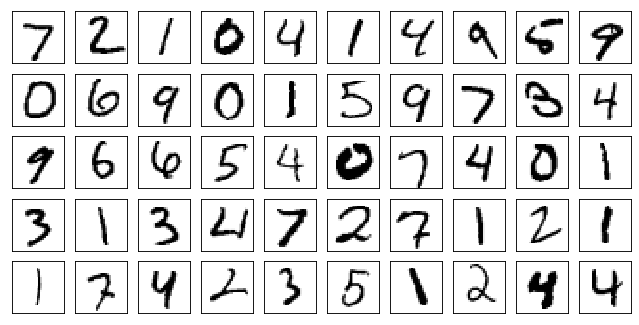

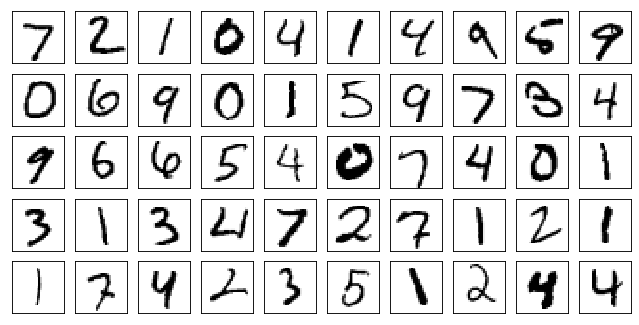

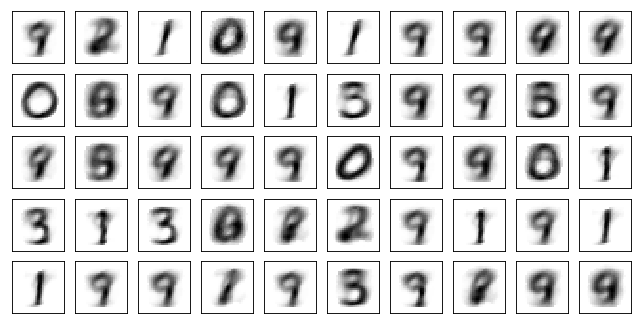

In [18]:
plot_mnist(data.data.numpy()[:50], (5, 10))
plot_mnist(data[:50], (5, 10))
plot_mnist(to_plot, (5, 10))

Two-neuron latent layer, plot 2D activations class-wise

In [19]:
list( models['128-2'].children() )

[Encoder(
   (fc1): Linear(in_features=784, out_features=128, bias=True)
   (fc2): Linear(in_features=128, out_features=2, bias=True)
 ), Decoder(
   (fc1): Linear(in_features=2, out_features=128, bias=True)
   (fc2): Linear(in_features=128, out_features=784, bias=True)
 )]

In [20]:
encoder_trained_128_2 = list(models['128-2'].children())[0]

In [21]:
data.size()

torch.Size([4000, 1, 28, 28])

In [22]:
subset = data.view(-1, 28*28)

In [23]:
subset.size()

torch.Size([4000, 784])

In [25]:
encoder_output_numpy = encoder_trained_128_2(subset).detach().numpy()

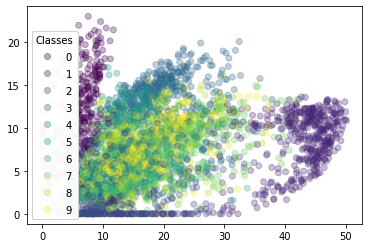

In [32]:
fig, ax = plt.subplots()

scatter = ax.scatter(encoder_output_numpy[:, 0], encoder_output_numpy[:, 1], c = labels, alpha = 0.3)

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)

# produce a legend with a cross section of sizes from the scatter
handles, leg_labels = scatter.legend_elements(prop="sizes", alpha=0.6)

plt.show()

32-neuron latent layer, reduce dimensionality with t-SNE, then plot 2D embedding class-wise

In [33]:
from sklearn.manifold import TSNE

In [34]:
encoder_trained_128_32 = list(models['128-32'].children())[0]
encoder_128_32_output = encoder_trained_128_32(subset).detach().numpy()

In [35]:
X_embedded = TSNE(n_components=2).fit_transform(encoder_output_numpy)

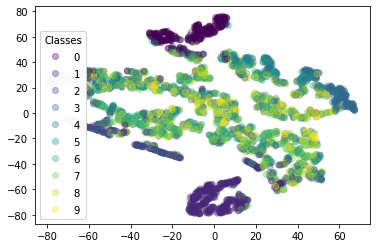

In [36]:
fig, ax = plt.subplots()

scatter = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], c = labels, alpha = 0.3)

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)

# produce a legend with a cross section of sizes from the scatter
handles, leg_labels = scatter.legend_elements(prop="sizes", alpha=0.6)

plt.show()